# Dissecting Chosen Model - Random Forest Classifier 

In [40]:
# Pipping required files

# !pip install imblearn
# !pip install shap

In [41]:
# Loading necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display, Markdown, Latex
import pickle as pk

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import shap

In [4]:
# Defining function to visualise 

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.005)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
# Taken from Zach (2021). 

In [5]:
# Loading the datasets

# Loading
Train = pd.read_csv('./Train_Validation_Test/TRUE_TRAIN.csv')
Test = pd.read_csv('./Train_Validation_Test/TRUE_TEST.csv')

# Drop artist column
Train.drop('artist_name', axis=1, inplace=True)
Test.drop('artist_name', axis=1, inplace=True)

# Prepping
X_fulltrain = Train.drop('Success', axis=1)
y_fulltrain = Train['Success']
X_test = Test.drop('Success', axis=1)
y_test = Test['Success']

# Dropping unnecessary columns (from feature selection in B)
final_eliminate = ['p_PCA7',
 'p_PCA6',
 'p_PCA3',
 'lyrics_PCA8',
 'p_PCA5',
 'audio_PCA3',
 'p_PCA4',
 'region_PCA5',
 '% of adult',
 'lyrics_PCA3',
 'lyrics_PCA7',
 'Playlist Passion Score',
 '% of teenager',
 'p_PCA10',
 'artist_passion_score',
 'audio_PCA5',
 'p_PCA8',
 'region_PCA3',
 'percentage of males',
 '% of children',
 'p_PCA9',
 '% of senior']

X_fulltrain.drop(final_eliminate, axis=1, inplace=True)
X_test.drop(final_eliminate, axis=1, inplace=True)

In [7]:
# Open model

chosen_rfc = pk.load(open('./Final_Model/Final_RandomForestClassifier.pkl', 'rb'))

In [8]:
# Checking confusion matrix

rfc_cm = confusion_matrix(y_test, chosen_rfc.predict(X_test))

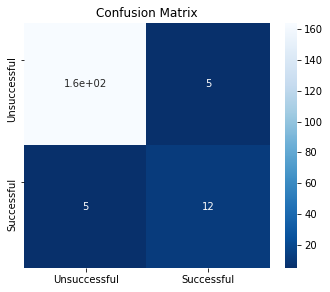

In [109]:
# Using seaborn

plt.figure(figsize=(5.5,4.5))
sns.heatmap(rfc_cm, annot=True, cmap='Blues_r')
plt.xticks([0.5,1.5], ['Unsuccessful', 'Successful'])
plt.yticks([0.3,1.3], ['Unsuccessful', 'Successful'])
plt.title('Confusion Matrix')
# plt.show();
plt.savefig('./Model_Evaluation_Images/Confusion_Matrix.png')

In [35]:
# Classification report

print(classification_report(y_test, chosen_rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       169
           1       0.71      0.71      0.71        17

    accuracy                           0.95       186
   macro avg       0.84      0.84      0.84       186
weighted avg       0.95      0.95      0.95       186



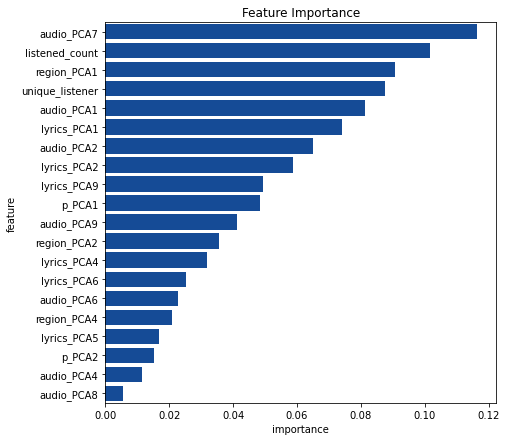

In [112]:
# Feature importances

features_list = X_fulltrain.columns.tolist()
feature_importances = chosen_rfc[2].feature_importances_
importances_df = pd.DataFrame({'feature': features_list, 'importance': feature_importances})
importances_df.sort_values(by='importance', ascending=False, inplace=True)
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=importances_df, color='#0047AB')
plt.title('Feature Importance')
plt.savefig('./Model_Evaluation_Images/feature_importances.png',  bbox_inches='tight')

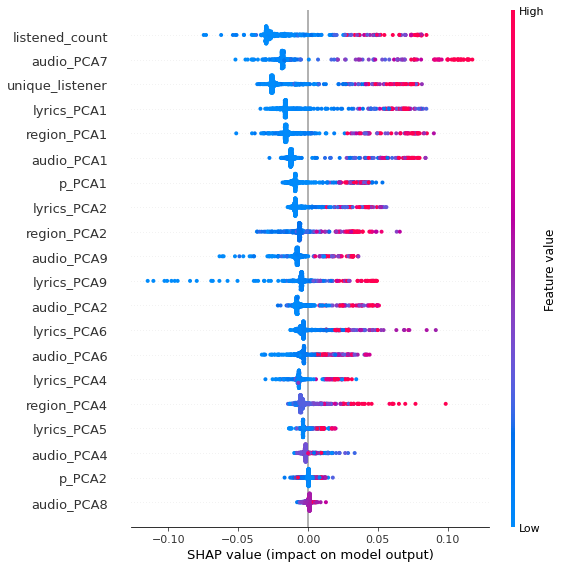

In [113]:
# Checking shap values

shap.initjs()
shap_df = X_fulltrain
explainer = shap.TreeExplainer(chosen_rfc[2])
shap_values = explainer.shap_values(shap_df, approximate=False, check_additivity=False)
shap.summary_plot(shap_values[1], shap_df, show=False)
plt.savefig('./Model_Evaluation_Images/SHAP_values.png',  bbox_inches='tight')

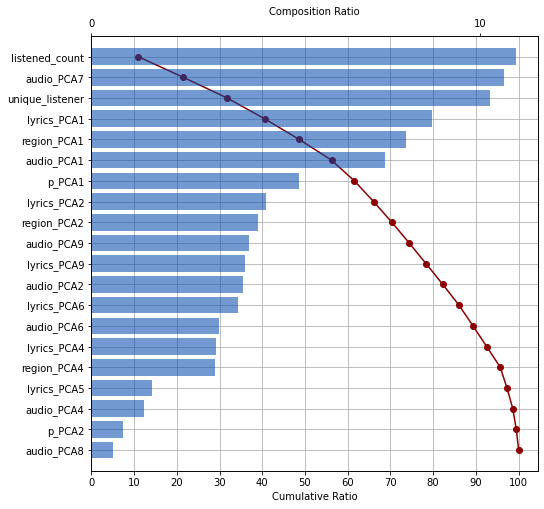

In [111]:
def make_shap_waterfall_plot(shap_values, features, num_display=20): # Taken from Shopenova (2020)
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='darkred', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.55, color='#0047AB')
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=10)
    plt.ylim(-1, len(column_list))
    
    # Shap waterfall plot
make_shap_waterfall_plot(shap_values[1], shap_df)
plt.savefig('./Model_Evaluation_Images/composition_ratio.png')

# Components We Should Look Into

1. Audio PCA7 - Will look at 2 audio features (Loudness and Speechiness)
2. Audio PCA1 - Will rely on looking at Audio PCA7
2. Lyrics PCA1 - Sacrificing Interpretability - Suggest that this can be a future Endeavor
3. Region PCA1 - Can be looked into
4. Playlist PCA1 - Can be looked into

Apply correlation concept: https://online.stat.psu.edu/stat505/lesson/11/11.4